<a href="https://colab.research.google.com/github/Yannik-H/House_Prices_Prediction/blob/master/House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%tensorflow_version 1.x
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import numpy as np
import keras
from matplotlib import pyplot as plt
import seaborn as sns

TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_data = pd.read_csv('../content/gdrive/My Drive/Colab Notebooks/Kaggle/HousePrices/train.csv', index_col=0)
test_data = pd.read_csv('../content/gdrive/My Drive/Colab Notebooks/Kaggle/HousePrices/test.csv', index_col=0)
submission = pd.read_csv('../content/gdrive/My Drive/Colab Notebooks/Kaggle/HousePrices/sample_submission.csv', index_col=0)

**Data visualization**

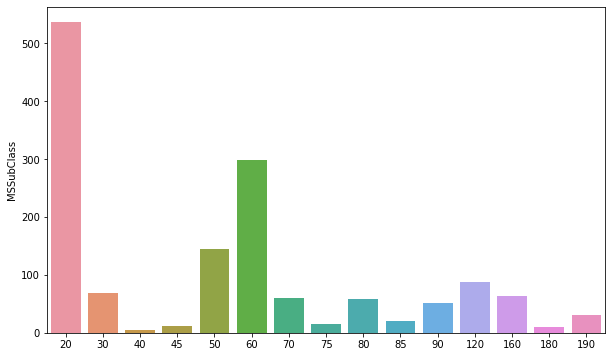

In [ ]:
plt.figure(figsize=(10,6))
plt.title("")
sns.barplot(x = train_data.MSSubClass.value_counts().index, y = train_data.MSSubClass.value_counts())

**Data Preprocessing**

In [ ]:
pip install category_encoders

In [ ]:
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
columns_with_missing = [col for col in train_data.columns 
                        if train_data[col].isnull().any()]
#19 columns have missing value
#columns_with_missing
#先试试最简单的，把那些缺失值比较多的特征去掉
#值得注意的是，这肯定不是好的方法，因为扔掉了5个特征
dropped_train_data = train_data[train_data.columns.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'])]
dropped_test_data = test_data[test_data.columns.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'])]

In [ ]:
X = dropped_train_data[dropped_train_data.columns.drop(['SalePrice'])]
y = dropped_train_data['SalePrice']
X_test = dropped_test_data.copy()

In [ ]:
numerical_imputer = SimpleImputer(strategy='median')
catagorical_imputer = SimpleImputer(strategy='most_frequent')
#38 catagorical columns
c_columns = [col for col in X.columns if X[col].dtype == 'object']
#36 numerical columns
n_columns = X.columns.drop(c_columns)

numerical_imputer.fit(X[n_columns])
n_imputed_X = pd.DataFrame(numerical_imputer.transform(X[n_columns]))
n_imputed_X.columns = n_columns
n_imputed_X.index = X.index
c_imputed_X = pd.DataFrame(catagorical_imputer.fit_transform(X[c_columns]))
c_imputed_X.columns = c_columns
c_imputed_X.index = X.index
imputed_X = n_imputed_X.join(c_imputed_X)

n_imputed_X_test = pd.DataFrame(numerical_imputer.transform(X_test[n_columns]))
n_imputed_X_test.columns = n_columns
n_imputed_X_test.index = X_test.index
c_imputed_X_test = pd.DataFrame(catagorical_imputer.transform(X_test[c_columns]))
c_imputed_X_test.columns = c_columns
c_imputed_X_test.index = X_test.index
imputed_X_test = n_imputed_X_test.join(c_imputed_X_test)

In [ ]:
len(c_columns)

38

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(imputed_X, y, train_size = 0.9, test_size = 0.1, random_state=0)

In [ ]:
n_X_train = X_train[n_columns]
n_X_valid = X_valid[n_columns]
n_X_test = n_imputed_X_test

c_X_train = X_train[c_columns]
c_X_valid = X_valid[c_columns]
c_X_test = c_imputed_X_test

In [ ]:
test = final_X_train.isnull().any()
test.loc[test.values == True]

Series([], dtype: bool)

In [ ]:
#Target Encoding after split data into training set and validition set
oh_cols = [col for col in c_X_train.columns if len(X_train[col].value_counts()) <= 4]
oh_enc = ce.OneHotEncoder(handle_unknown='ignore')
oh_X_train = pd.DataFrame(oh_enc.fit_transform(X_train[oh_cols]))
oh_X_train.index = X_train.index
count_enc = ce.CountEncoder(handle_unknown='ignore')
count_enc.fit(c_X_train.drop(oh_cols, axis=1))
ce_cat_X = count_enc.transform(c_X_train.drop(oh_cols, axis=1))
processed_X_train = oh_X_train.join(ce_cat_X)

oh_X_valid = pd.DataFrame(oh_enc.transform(X_valid[oh_cols]))
oh_X_valid.index = X_valid.index
ce_cat_X_valid = count_enc.transform(c_X_valid.drop(oh_cols, axis=1))
processed_X_valid = oh_X_valid.join(ce_cat_X_valid)

oh_X_test = pd.DataFrame(oh_enc.transform(c_X_test[oh_cols]))
oh_X_test.index = c_X_test.index
ce_cat_X_test = count_enc.transform(c_X_test.drop(oh_cols, axis=1))
processed_X_test = oh_X_test.join(ce_cat_X_test)

In [ ]:
processed_X_test.head()

,Street_1,Street_2,LotShape_1,LotShape_2,LotShape_3,LotShape_4,LandContour_1,LandContour_2,LandContour_3,LandContour_4,Utilities_1,Utilities_2,LandSlope_1,LandSlope_2,LandSlope_3,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,ExterQual_1,ExterQual_2,ExterQual_3,ExterQual_4,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,CentralAir_1,CentralAir_2,KitchenQual_1,KitchenQual_2,KitchenQual_3,KitchenQual_4,GarageFinish_1,GarageFinish_2,GarageFinish_3,PavedDrive_1,PavedDrive_2,PavedDrive_3,MSZoning,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterCond,Foundation,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,Electrical,Functional,GarageType,GarageQual,GarageCond,SaleType,SaleCondition
930,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1036,958,36,1137,1303,1099,652,1021,1289,463,452,1154,575,372,1164,1284,666,1194,1223,856,1252,1264,1144,1088
656,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1036,958,201,1137,1303,1099,652,1021,1289,197,183,1154,573,198,1164,1284,666,1194,1223,856,1252,1264,1144,1088
45,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1036,958,71,1137,1303,103,652,261,1289,187,182,1154,575,372,1164,1284,666,1194,1223,856,1252,1264,1144,1088
1348,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,1036,958,52,1137,1303,1099,652,1021,1289,463,452,1154,575,372,1164,1284,666,1194,1223,856,1252,1264,1144,1088
55,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1036,958,201,1137,1303,1099,652,1021,1289,197,136,1154,573,135,1164,1284,224,1194,1223,856,1252,1264,1144,1088


In [ ]:
numerical_imputer2 = SimpleImputer(strategy='median')
numerical_imputer2.fit(processed_X_train)
processed_X_valid_t = pd.DataFrame(numerical_imputer2.transform(processed_X_valid))
processed_X_valid_t.columns = processed_X_valid.columns
processed_X_valid_t.index = processed_X_valid.index
processed_X_test_t = pd.DataFrame(numerical_imputer2.transform(processed_X_test))
processed_X_test_t.columns = processed_X_test.columns
processed_X_test_t.index = processed_X_test.index

In [ ]:
final_X_train = processed_X_train.join(n_X_train)
final_X_valid = processed_X_valid_t.join(n_X_valid)
final_X_test = processed_X_test_t.join(n_X_test)

In [ ]:
final_X_valid.head()

,Street_1,Street_2,LotShape_1,LotShape_2,LotShape_3,LotShape_4,LandContour_1,LandContour_2,LandContour_3,LandContour_4,Utilities_1,Utilities_2,LandSlope_1,LandSlope_2,LandSlope_3,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,ExterQual_1,ExterQual_2,ExterQual_3,ExterQual_4,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,CentralAir_1,CentralAir_2,KitchenQual_1,KitchenQual_2,KitchenQual_3,...,GarageQual,GarageCond,SaleType,SaleCondition,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
530,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1252.0,1264.0,1144.0,8.0,20.0,69.0,32668.0,6.0,3.0,1957.0,1975.0,0.0,1219.0,0.0,816.0,2035.0,2515.0,0.0,0.0,2515.0,1.0,0.0,3.0,0.0,4.0,2.0,9.0,2.0,1975.0,2.0,484.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,3.0,2007.0
492,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1252.0,1264.0,1144.0,1088.0,50.0,79.0,9490.0,6.0,7.0,1941.0,1950.0,0.0,403.0,165.0,238.0,806.0,958.0,620.0,0.0,1578.0,1.0,0.0,1.0,0.0,3.0,1.0,5.0,2.0,1941.0,1.0,240.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,8.0,2006.0
460,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1252.0,1264.0,1144.0,1088.0,50.0,69.0,7015.0,5.0,4.0,1950.0,1950.0,161.0,185.0,0.0,524.0,709.0,979.0,224.0,0.0,1203.0,1.0,0.0,1.0,0.0,3.0,1.0,5.0,1.0,1950.0,1.0,352.0,0.0,0.0,248.0,0.0,0.0,0.0,0.0,7.0,2009.0
280,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1252.0,1264.0,1144.0,1088.0,60.0,83.0,10005.0,7.0,5.0,1977.0,1977.0,299.0,392.0,0.0,768.0,1160.0,1156.0,866.0,0.0,2022.0,0.0,0.0,2.0,1.0,4.0,1.0,8.0,1.0,1977.0,2.0,505.0,288.0,117.0,0.0,0.0,0.0,0.0,0.0,3.0,2008.0
656,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1252.0,1264.0,1144.0,16.0,160.0,21.0,1680.0,6.0,5.0,1971.0,1971.0,381.0,0.0,0.0,525.0,525.0,525.0,567.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,6.0,0.0,1971.0,1.0,264.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0


In [ ]:
X_train = np.array(final_X_train)
y_train = np.array(y_train)
X_valid = np.array(final_X_valid)
y_valid = np.array(y_valid)
X_test = np.array(final_X_test)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1314, 107)
(146, 107)
(1459, 107)


In [ ]:
test = [col for col in processed_X_train.columns if col not in processed_X_valid.columns]
test

[]

**Baseline model(XGBoosting)**

In [ ]:
from xgboost import XGBRegressor

In [ ]:
my_xgbregressor = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_xgbregressor.fit(X_train, y_train, early_stopping_rounds = 5, eval_set=[(X_valid, y_valid)])

[16:06:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:188997
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:180435
[2]	validation_0-rmse:172098
[3]	validation_0-rmse:164640
[4]	validation_0-rmse:157166
[5]	validation_0-rmse:150485
[6]	validation_0-rmse:143821
[7]	validation_0-rmse:137631
[8]	validation_0-rmse:131560
[9]	validation_0-rmse:126102
[10]	validation_0-rmse:120681
[11]	validation_0-rmse:115679
[12]	validation_0-rmse:110986
[13]	validation_0-rmse:106820
[14]	validation_0-rmse:102381
[15]	validation_0-rmse:98368
[16]	validation_0-rmse:94375.9
[17]	validation_0-rmse:91306.9
[18]	validation_0-rmse:87875.1
[19]	validation_0-rmse:84702.6
[20]	validation_0-rmse:81610.5
[21]	validation_0-rmse:78776.1
[22]	validation_0-rmse:76046.1
[23]	validation_0-rmse:73240.6
[24]	validation_0-rmse:70722.4
[25]	validation_0-rmse:68168.7
[26]	validation_0-rmse:66044.9

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
prices_pridiction = my_xgbregressor.predict(X_test)

In [ ]:
prices_pridiction = prices_pridiction[:, np.newaxis]

In [ ]:
submission.SalePrice = prices_pridiction
submission.head()

,SalePrice
Id,
1461,122040.695312
1462,160211.843750
1463,183047.000000
1464,183759.656250
1465,202156.265625


In [ ]:
submission.to_csv('../content/gdrive/My Drive/Colab Notebooks/Kaggle/HousePrices/submission2.csv')

**Baseline model(RandomForest)**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
my_RFR = RandomForestRegressor(n_estimators=1000)
my_RFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
prediction_valid = my_RFR.predict(X_valid)
np.sqrt(mean_squared_error(y_valid, prediction_valid))

29350.579025083767

In [ ]:
np.where(np.isnan(X_valid))

(array([ 45, 222]), array([56, 55]))

**Baseline model(lightGBM)**